<a href="https://colab.research.google.com/github/ShynOR/customer_churn_analyst/blob/main/ML_CustomerChurn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Modules and Loading Dataset

In [2]:
# importing spark session
from pyspark.sql import SparkSession

# data visualization modules
import matplotlib.pyplot as plt
import plotly.express as px
from IPython.display import display, HTML
import seaborn as sns

# pandas module
import pandas as pd

# pyspark SQL functions
from pyspark.sql.functions import *

# pyspark data preprocessing modules
from pyspark.ml.feature import Imputer, StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder

# pyspark data modeling and model evaluation modules
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator



### Building our Spark Session

In [3]:
spark = SparkSession.builder.appName("Customer_Churn_Prediction").getOrCreate()

In [4]:
data = spark.read.format('csv').option('inferSchema',True).option('header',True).load('/content/dataset.csv')

In [6]:
###Print the data schema to check out the data types
data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Churn: string (nullable = true)



In [7]:
# Data Dimension
data.count()

7043

In [8]:
data.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

# Exploratory Data Analysis


In [10]:
#Show the dataset
data.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|           No|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [11]:
#Clarify which columns is the numerical ones
numerical_columns = [name for name,typ in data.dtypes if typ == "double" or typ == "int"]
numerical_columns

['tenure', 'MonthlyCharges', 'TotalCharges']

In [13]:
#Clarify which columns is the catogorical ones
categorical_columns = [name for name,typ in data.dtypes if typ == "string"]
categorical_columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [15]:
#Let's get all the numerical features and store them into a pandas dataframe.
df = data.select('tenure', 'MonthlyCharges', 'TotalCharges').toPandas()
df

,tenure,MonthlyCharges,TotalCharges
0,1,29.85,29.85
1,34,56.95,1889.50
2,2,53.85,108.15
3,45,42.30,1840.75
4,2,70.70,151.65
...,...,...,...
7038,24,84.80,1990.50
7039,72,103.20,7362.90
7040,11,29.60,346.45
7041,4,74.40,306.60


<ipython-input-16-d7b789175233>:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(ax = ax, bins = 20)


count    7043.000000
mean       32.435752
std        25.075228
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max       458.000000
Name: tenure, dtype: float64

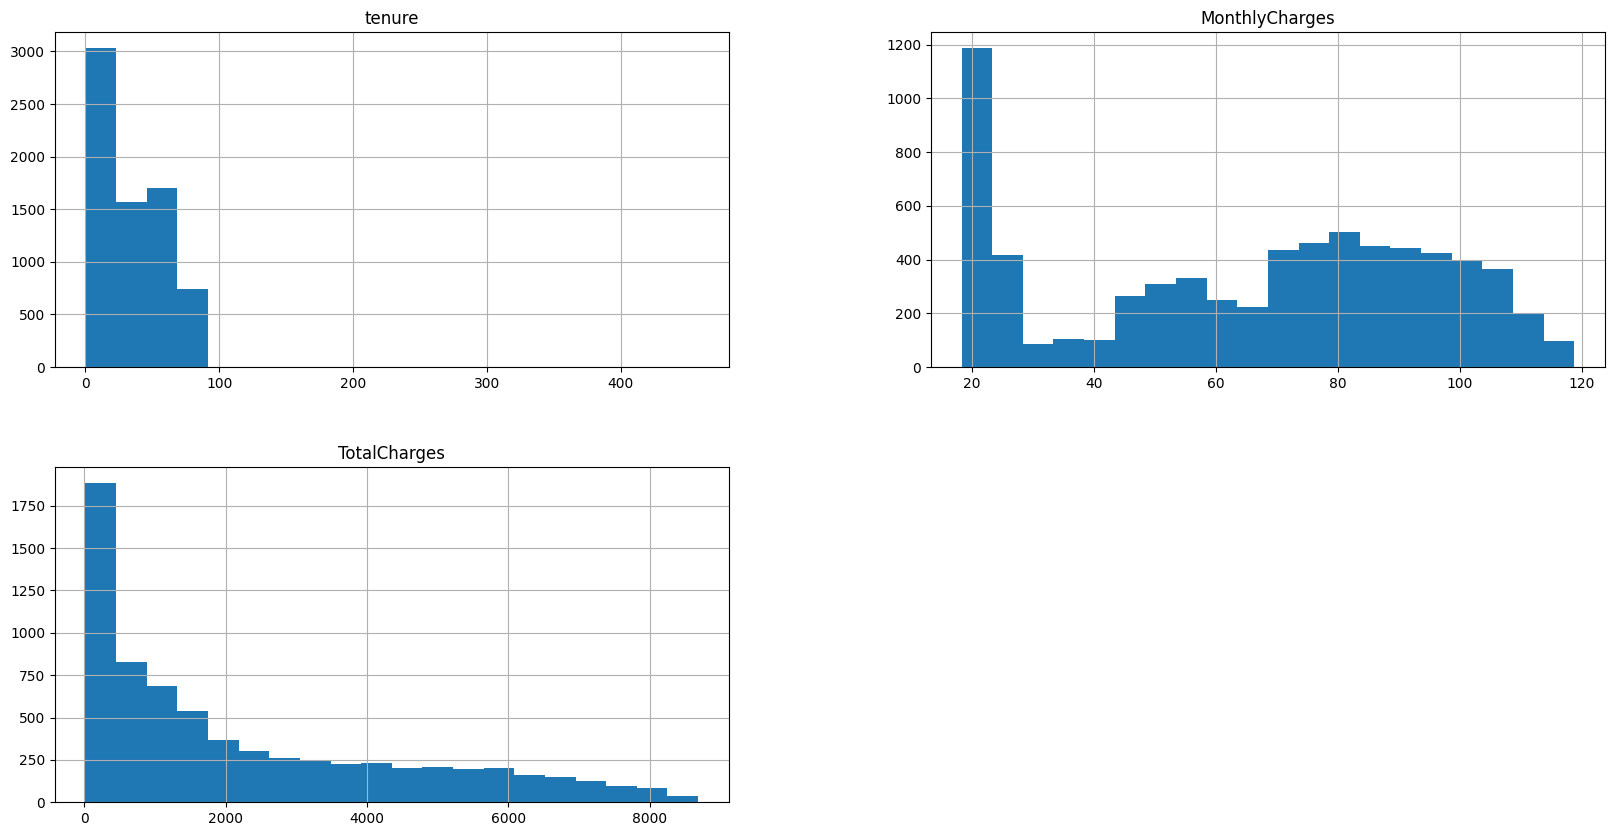

In [16]:
fig = plt.figure(figsize = (20,10))
ax = fig.gca()
df.hist(ax = ax, bins = 20)
df.tenure.describe()

From the plot, we can see that outlier for the tenure is 458. -> which is much greater than the mean of the distribution

Lets generate the correlation matrix

<Axes: >

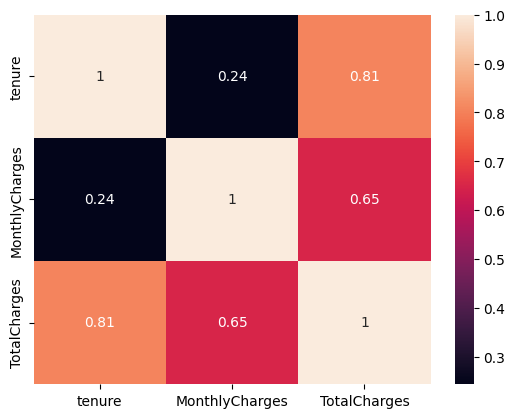

In [17]:
sns.heatmap(df.corr() , annot=True)

Let's check the unique value count per each categorical variables

In [19]:
data.groupby("Contract").count().show()

+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



Let's find number of null values in all of our dataframe columns

In [21]:
data.select(count(when(col("Churn").isNull(),"Churn")).alias("Churn")).show()#0 in the columns of Churn

+-----+
|Churn|
+-----+
|    0|
+-----+



### Data Preprocessing


**Handling the missing values** <br>


In [23]:
data.select(count(when(col("TotalCharges").isNull(),"TotalCharges")).alias("TotalCharges")).show()

+------------+
|TotalCharges|
+------------+
|          11|
+------------+



In [24]:
columns_with_missing_values = ['TotalCharges']

Creating our Imputer - replacing with the mean value for the NaN

In [25]:
imputer = Imputer(inputCols = columns_with_missing_values, outputCols = columns_with_missing_values).setStrategy("mean")

Use Imputer to fill the missing values

In [26]:
imputer = imputer.fit(data)
data= imputer.transform(data)

Let's check the missing value counts again

In [27]:
data.select(count(when(col("TotalCharges").isNull(),"TotalCharges")).alias("TotalCharges")).show()

+------------+
|TotalCharges|
+------------+
|           0|
+------------+



**Removing the outliers** <br>
Let's find the customer with the tenure higher than 100

In [28]:
data.select('*').where(data.tenure > 100).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|   PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+----------------+--------------+------------+-----+
|5122-CYFXA|Female|           No|     No|        No|   458|         Yes|           No|            DSL|            No|         Yes|              No|        Yes|        Yes|            Yes|

In [29]:
print("Before removing the outlier", data.count())
data = data.filter(data.tenure < 100)
print("After removing the outlier",  data.count())

Before removing the outlier 7043
After removing the outlier 7042


In [30]:
numerical_vector_assembler = VectorAssembler(inputCols = numerical_columns, outputCol = "numerical_features_vectors")

### **Feature Preparation**
- Numerical Features
    - Vector Assembling
    - Numerical Scaling
- Categorical Features
    - String Indexing
    - Vector Assembling

- Combining the numerical and categorical feature vectors




**Feature Preparation - Numerical Features** <br>

`Vector Assembling --> Standard Scaling` <br>

**Vector Assembling** <br>
To apply our machine learning model we need to combine all of our numerical and categorical features into vectors. For now let's create a feature vector for our numerical columns.


In [31]:
data = numerical_vector_assembler.transform(data)

In [33]:
data.select("*").show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|numerical_features_vectors|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------

**Numerical Scaling** <br>
Let's standardize all of our numerical features.

In [34]:
scaler = StandardScaler(inputCol = "numerical_features_vectors",
                        outputCol= "numerical_features_scaled",withStd = True, withMean = True)
data = scaler.fit(data).transform(data)
data.select('numerical_features_vectors', 'numerical_features_scaled').show()

+--------------------------+-------------------------+
|numerical_features_vectors|numerical_features_scaled|
+--------------------------+-------------------------+
|         [1.0,29.85,29.85]|     [-1.2775627682208...|
|       [34.0,56.95,1889.5]|     [0.06615490566075...|
|        [2.0,53.85,108.15]|     [-1.2368440508304...|
|       [45.0,42.3,1840.75]|     [0.51406079695460...|
|         [2.0,70.7,151.65]|     [-1.2368440508304...|
|         [8.0,99.65,820.5]|     [-0.9925317464883...|
|        [22.0,89.1,1949.4]|     [-0.4224697030234...|
|        [10.0,29.75,301.9]|     [-0.9110943117076...|
|      [28.0,104.8,3046.05]|     [-0.1781573986813...|
|      [62.0,56.15,3487.95]|     [1.20627899259056...|
|       [13.0,49.95,587.45]|     [-0.7889381595366...|
|        [16.0,18.95,326.8]|     [-0.6667820073655...|
|      [58.0,100.35,5681.1]|     [1.04340412302915...|
|       [49.0,103.7,5036.3]|     [0.67693566651600...|
|      [25.0,105.5,2686.05]|     [-0.3003135508523...|
|      [69

**Feature Preperation - Categorical Features** <br>

`String Indexing --> Vector Assembling` <br>

**String Indexing** <br>
We need to convert all the string columns to numeric columns.

In [35]:
categorical_columns_indexed = [name + "_Indexed" for name in categorical_columns]
categorical_columns_indexed

['customerID_Indexed',
 'gender_Indexed',
 'SeniorCitizen_Indexed',
 'Partner_Indexed',
 'Dependents_Indexed',
 'PhoneService_Indexed',
 'MultipleLines_Indexed',
 'InternetService_Indexed',
 'OnlineSecurity_Indexed',
 'OnlineBackup_Indexed',
 'DeviceProtection_Indexed',
 'TechSupport_Indexed',
 'StreamingTV_Indexed',
 'StreamingMovies_Indexed',
 'Contract_Indexed',
 'PaperlessBilling_Indexed',
 'PaymentMethod_Indexed',
 'Churn_Indexed']

In [36]:
indexer = StringIndexer(inputCols = categorical_columns, outputCols = categorical_columns_indexed)
data = indexer.fit(data).transform(data)

In [37]:
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       P

Let's combine all of our categorifal features in to one feature vector.

In [38]:
categorical_columns_indexed.remove("customerID_Indexed")
categorical_columns_indexed.remove("Churn_Indexed")

In [39]:
categorical_vector_assembler = VectorAssembler(inputCols = categorical_columns_indexed, outputCol = 'categorical_features')

In [40]:
data = categorical_vector_assembler.transform(data)
data.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+--------------------------+-------------------------+------------------+--------------+---------------------+---------------+------------------+--------------------+---------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+-------------------+-----------------------+----------------+------------------------+---------------------+-------------+--------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|Pape

Combine categorical and numerical feature vectors

In [42]:
final_vector_assembler = VectorAssembler(inputCols = ["categorical_features","numerical_features_scaled"], outputCol = "final_feature_vector")
data = final_vector_assembler.transform(data)

In [43]:
data.select(["final_feature_vector","Churn_Indexed"]).show()

+--------------------+-------------+
|final_feature_vector|Churn_Indexed|
+--------------------+-------------+
|(19,[0,2,4,5,6,8,...|          0.0|
|(19,[6,7,9,13,14,...|          0.0|
|(19,[6,7,8,15,16,...|          1.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[0,16,17,18],...|          1.0|
|(19,[0,5,9,11,12,...|          1.0|
|(19,[3,5,8,11,15,...|          0.0|
|(19,[0,4,5,6,7,14...|          0.0|
|(19,[0,2,5,9,10,1...|          1.0|
|(19,[3,6,7,8,13,1...|          0.0|
|(19,[2,3,6,7,15,1...|          0.0|
|[0.0,0.0,0.0,0.0,...|          0.0|
|(19,[2,5,9,11,12,...|          0.0|
|(19,[5,8,9,11,12,...|          1.0|
|(19,[7,9,10,11,12...|          0.0|
|[1.0,0.0,1.0,1.0,...|          0.0|
|[1.0,0.0,0.0,0.0,...|          0.0|
|[0.0,0.0,0.0,1.0,...|          0.0|
|(19,[0,2,3,6,9,10...|          1.0|
|(19,[0,8,9,12,16,...|          0.0|
+--------------------+-------------+
only showing top 20 rows



# Trainning the Machine Learning

Train and test data splitting


In [44]:
train, test = data.randomSplit([0.7,0.3], seed = 100)

In [45]:
train.count()

4930

In [46]:
test.count()

2112

Create the model for the Decision Tree ML

In [47]:
dt = DecisionTreeClassifier(featuresCol = "final_feature_vector", labelCol = "Churn_Indexed", maxDepth = 3)

In [48]:
model = dt.fit(train)

In [50]:
prediction_test = model.transform(test)

In [51]:
prediction_test.select(["Churn","prediction"]).show()

+-----+----------+
|Churn|prediction|
+-----+----------+
|  Yes|       1.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|  Yes|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
|   No|       0.0|
+-----+----------+
only showing top 20 rows



# Evaluating the Model

* Calculating area under the ROC curve for the test set

In [53]:
evaluator = BinaryClassificationEvaluator(labelCol = "Churn_Indexed")

In [54]:
auc_test = evaluator.evaluate(prediction_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7678230877272001

* Calculating area under the ROC curve for the training set

In [55]:
prediction_train = model.transform(train)
auc_train = evaluator.evaluate(prediction_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.7721112330375414

* Hyper parameter tuning - by changing about the max_depth - parameter of the Decision Tree Model

In [62]:
def evaluate_dt(model_params):
  test_accuracies  = []
  train_accuracies = []

  for maxD in model_params:
    #train the model based on the maxD
    decision_tree = DecisionTreeClassifier(featuresCol = 'final_feature_vector',
                                           labelCol = 'Churn_Indexed', maxDepth = maxD)
    dtModel = decision_tree.fit(train)

    #calculating the test error
    predictions_test = dtModel.transform(test)
    evaluator = BinaryClassificationEvaluator(labelCol = "Churn_Indexed")
    auc_test = evaluator.evaluate(predictions_test, {evaluator.metricName: "areaUnderROC"})

    #Recording the accuracy
    test_accuracies.append(auc_test)

    #Calculating the training error
    predictions_training = dtModel.transform(train)
    evaluator = BinaryClassificationEvaluator(labelCol = "Churn_Indexed")
    auc_training = evaluator.evaluate(predictions_training, {evaluator.metricName: "areaUnderROC"})
    train_accuracies.append(auc_training)
  return (test_accuracies, train_accuracies)





In [63]:
maxDepths = [i for i in range(2,21)]

In [64]:
test_accs, train_accs = evaluate_dt(maxDepths)
print(train_accs)
print(test_accs)

[0.7737711024910238, 0.7721112330375414, 0.6732017750857608, 0.5647403286677019, 0.797607974377661, 0.7600331160893413, 0.7616399322585649, 0.7851198149534798, 0.82591977092655, 0.8633625692715379, 0.8899907318309699, 0.9236516335825413, 0.9402616892332477, 0.9521037242780167, 0.9662424766482165, 0.9763120733848871, 0.9807472862567603, 0.9853808496196841, 0.9883361989750398]
[0.7918744332963926, 0.7678230877272001, 0.6938514510575503, 0.5664944085244075, 0.7968240892739675, 0.7464077658395512, 0.7486976928866473, 0.7390283218461648, 0.7568262227463716, 0.7717528253693575, 0.770466222983424, 0.7493673661690539, 0.7371905724224987, 0.7208594338001293, 0.7102797812005524, 0.704298946894316, 0.7036452746549405, 0.6956814962753128, 0.6895714683623821]


* Lets visualize the results

In [67]:
df = pd.DataFrame()

In [68]:
df['maxDepths'] = maxDepths
df['train_accs']= train_accs
df['test_accs']= test_accs


In [69]:
df

,maxDepths,train_accs,test_accs
0,2,0.773771,0.791874
1,3,0.772111,0.767823
2,4,0.673202,0.693851
3,5,0.564740,0.566494
4,6,0.797608,0.796824
5,7,0.760033,0.746408
6,8,0.761640,0.748698
7,9,0.785120,0.739028
8,10,0.825920,0.756826
9,11,0.863363,0.771753


Draw the double line chart to see the effective of boths

In [71]:
px.line(df, x = "maxDepths", y = ["train_accs","test_accs"])

* Applying the new best parameters for our model with max_depth = 6

In [80]:
dt = DecisionTreeClassifier(featuresCol = "final_feature_vector", labelCol = "Churn_Indexed", maxDepth = 6)
model = dt.fit(train)

In [87]:
prediction_train = model.transform(train)
auc_train = evaluator.evaluate(prediction_train, {evaluator.metricName: "areaUnderROC"})
auc_train

0.797607974377661

The parameter value that achieves a train and test set accuracy of 80% is maxDepth = 6. However, beyond this point, the model starts to overfit the data, which is undesirable. Therefore, in this case, choosing maxDepth = 6 is the optimal choice for us.






In [88]:
prediction_test = model.transform(test)
auc_test = evaluator.evaluate(prediction_test, {evaluator.metricName: "areaUnderROC"})
auc_test

0.7968240892739675

## Model Deployment

* Defining the solution to reduce the customer churn

In [81]:
feature_importance = model.featureImportances

In [82]:
feature_importance

SparseVector(19, {0: 0.0012, 1: 0.0051, 3: 0.0052, 4: 0.0137, 5: 0.0189, 6: 0.1457, 7: 0.0337, 10: 0.0025, 11: 0.0138, 12: 0.0103, 13: 0.5048, 14: 0.0026, 15: 0.0186, 16: 0.2075, 17: 0.0115, 18: 0.005})

In [83]:
scores = [score for i,score in enumerate(feature_importance)]

In [84]:
scores

[0.0012458380271707756,
 0.005061505966322667,
 0.0,
 0.005199436353121312,
 0.013660525158140351,
 0.018869589202896865,
 0.14565730856404152,
 0.03365494880670869,
 0.0,
 0.0,
 0.0025086634426406537,
 0.013846232534722367,
 0.010285800594289674,
 0.504752123280422,
 0.002570605749866359,
 0.018582672583223995,
 0.20753761020590827,
 0.011537693498177489,
 0.005029446032347225]

In [85]:
df = pd.DataFrame(scores, columns = ["score"], index = categorical_columns_indexed + numerical_columns)

In [86]:
df

,score
gender_Indexed,0.001246
SeniorCitizen_Indexed,0.005062
Partner_Indexed,0.000000
Dependents_Indexed,0.005199
PhoneService_Indexed,0.013661
MultipleLines_Indexed,0.018870
InternetService_Indexed,0.145657
OnlineSecurity_Indexed,0.033655
OnlineBackup_Indexed,0.000000
DeviceProtection_Indexed,0.000000


In [89]:
px.bar(df, y ="score")

In [90]:
df = data.groupby(["Contract","Churn"]).count().toPandas()

In [91]:
df

,Contract,Churn,count
0,Month-to-month,No,2219
1,Month-to-month,Yes,1655
2,Two year,Yes,48
3,One year,No,1307
4,One year,Yes,166
5,Two year,No,1647


In [92]:
px.bar(df, x = "Contract", y ='count',color = 'Churn')

From this bar chart, we can see that the "Month-to-Month" has higher churn rate compared to "One-year" or "Two-year". The company can consider to have more intensive or some discounts or transfer them into the One-year or Two-year long-term contracts.